# Jakub's FYP particle tracking script

In this script we will take a video input from our high speed camera and perform particle tracking on it to derive a normalised velocity field.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import morphology, util, filters, io, exposure, data
import numpy as np
import pandas as pd
import trackpy as tp
from pandas import DataFrame, Series  # for convenience
from IPython.display import display, HTML
import pims
import os
import cv2
import random
from datetime import datetime

# Define some utility functions that we will use later
def generate_filename(extension):
   time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

   if (extension != ""):
      fname = f"Capture_{time}.{str(extension)}"
      return fname
    
   return f"Capture_{time}"

def is_variable_loaded(name):
    return name in globals()

def save_table_backup(table,name):
    table.to_pickle(os.path.join(WORKING_PATH,'Data',name))

def read_table_backup(name):
    return pd.read_pickle(os.path.join(WORKING_PATH,'Data',name))  
  

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
display(HTML("<style>div.output_scroll { height: max-content; }</style>"))

In [2]:
FOLDER_NAME = "VideoCapture_10-03-2022_15-36-13 (Attempt 8 - 4g graphite - fresh, 200ml deionised, 0.5ml fairy)"
WORKING_PATH = 'C:\\Users\\jakub\\Desktop\\graphene\\tests\\Particle tracking'
OUTPUTS_PATH = os.path.join(WORKING_PATH, 'Output files')

IMAGES_PATH =  os.path.join(WORKING_PATH, 'Images', FOLDER_NAME, "*.jpg")
print(IMAGES_PATH)
FRAMES_PER_SECOND = 483.33
FRAME_TIME = 1 / FRAMES_PER_SECOND

C:\Users\jakub\Desktop\graphene\tests\Particle tracking\Images\VideoCapture_10-03-2022_15-36-13 (Attempt 8 - 4g graphite - fresh, 200ml deionised, 0.5ml fairy)\*.jpg


### Load the variables from memory if they have been precalculated earlier

This is handy if you want to carry on working on your dataset after restarting Jupyter Notebook. Those datasets can take a while to calculate, so I thought it would make a lot of sense to back them up to disk and attempt to read them if they're available before recalculating.

In [3]:
# Load variables is available to speed up workflow
if not (is_variable_loaded("f_0")):
    try:
        f = read_table_backup("f_0.pkl")
        print("Loaded f_0.pkl from memory")
    except:
        print("The file f_0.pkl does not exist")

if not (is_variable_loaded("f")):
    try:
        f = read_table_backup("f.pkl")
        print("Loaded f.pkl from memory")
    except:
        print("The file f.pkl does not exist")
        
if not (is_variable_loaded("t")):
    try:
        t = read_table_backup("t.pkl")
        print("Loaded t.pkl from memory")
    except:
        print("The file t.pkl does not exist")
        
if not (is_variable_loaded("t1")):
    try:
        t1 = read_table_backup("t1.pkl")
        print("Loaded t1.pkl from memory")
    except:
        print("The file t1.pkl does not exist")
        
if not (is_variable_loaded("t2")):
    try:
        t2 = read_table_backup("t2.pkl")
        print("Loaded t2.pkl from memory")
    except:
        print("The file t2.pkl does not exist")
        
if not (is_variable_loaded("v_data")):
    try:
        v_data = read_table_backup("v_data.pkl")
        print("Loaded v_data.pkl from memory")
    except:
        print("The file v_data.pkl does not exist")
        
if not (is_variable_loaded("v_data_filtered")):
    try:
        v_data = read_table_backup("v_data_filtered.pkl")
        print("Loaded v_data_filtered.pkl from memory")
    except:
        print("The file v_data_filtered.pkl does not exist")

Loaded f_0.pkl from memory
Loaded t.pkl from memory
Loaded t1.pkl from memory
Loaded t2.pkl from memory
Loaded v_data.pkl from memory
Loaded v_data_filtered.pkl from memory


Frame time: 2.07 ms


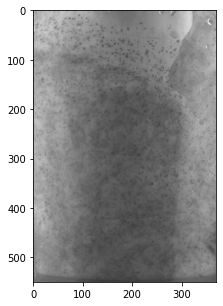

In [4]:
@pims.pipeline
def gray(image):
    return image[:, :, 0]  # Take just the green channel

@pims.pipeline
def crop(img):
    """
    Crop the image to select the region of interest
    """
    x_min = 400
    x_max = 770
    y_min = 300
    y_max = 850
    
    return img[y_min:y_max,x_min:x_max]

rawframes = crop(pims.open(IMAGES_PATH))
plt.imshow(rawframes[550]);


print(f"Frame time: {FRAME_TIME*1000:.2f} ms")

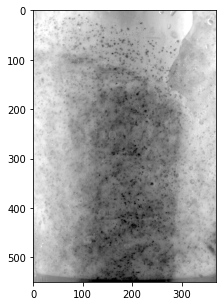

In [5]:
@pims.pipeline
def preprocess_foam(img):
    """
    Apply image processing functions to return a binary image
    """
    # Crop the pictures as for raw images.
    img = gray(crop(img))
    
    percentiles = np.percentile(img, (0.5, 99.5))
    # array([ 1., 28.])
    scaled = exposure.rescale_intensity(img, in_range=tuple(percentiles))
    image_bright = exposure.adjust_gamma(scaled, gamma=0.5,gain=1)
    
#     print(img.max(), img.min())
    
#     img_scaled = exposure.rescale_intensity(img)
#     print(img_scaled.max(), img_scaled.min())
    
    # Apply thresholds
#     adaptive_thresh = filters.threshold_local(img,35)
#     idx = img > adaptive_thresh
#     idx2 = img < adaptive_thresh
#     img[idx] = 0
#     img[idx2] = 255
#     img = ndimage.binary_dilation(img)
#     img = ndimage.binary_dilation(img)
    return util.img_as_int(image_bright)


frames = preprocess_foam(pims.open(os.path.join(IMAGES_PATH)))
plt.imshow(frames[550]);

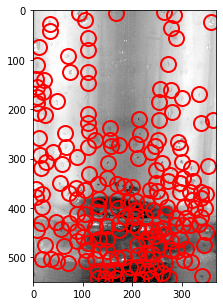

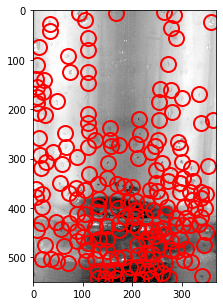

In [6]:


if not (is_variable_loaded("f_0")):
    frame_no = 0
    f_0 = tp.locate(frames[frame_no], 11, invert=True, minmass=35000)
    save_table_backup(f_0,"f_0.pkl")
    tp.annotate(f_0, frames[frame_no]);
 
frame_no = 0
f_0 = tp.locate(frames[frame_no], 11, invert=True, minmass=35000)
plt.imshow(frames[frame_no])
tp.annotate(f_0, frames[frame_no]);

In [7]:
display(f_0.head(10))
f_0.shape

y           x           mass      size       ecc       signal  \
1    4.443496  263.825568   44813.448925  2.490385  0.249968  2520.855551   
2    5.332119  167.762539   45286.287954  2.555904  0.330877  1986.443527   
3    5.965684   91.985588  130384.323187  2.788211  0.330512  5455.575154   
4    8.644009  284.771886   91938.613061  2.939274  0.439537  3227.256277   
8   19.882568  104.241401  128781.866520  3.082387  0.334747  4406.236231   
9   23.134594  358.595750   52173.110479  2.225722  0.141146  3138.923711   
14  28.691555   32.896138   98312.587100  2.867372  0.282853  3593.316823   
17  35.890491  278.139318   44169.920202  2.599232  0.428782  2462.919780   
20  41.523719   33.948534   37789.191320  2.322893  0.320300  2406.542819   
27  55.673428  287.938136   45263.165606  2.925343  0.233833  1404.227997   

     raw_mass        ep  
1    714943.0  0.473588  
2   1062032.0  0.201546  
3    667405.0  0.580995  
4    734609.0  0.439942  
8    756329.0  0.407934  
9    413744.0 -2.764432  
14   382262.0 -1.612252  
17   639644.0  0.669691  
20   163822.0 -0.414257  
27   666630.0  0.583151

(198, 8)

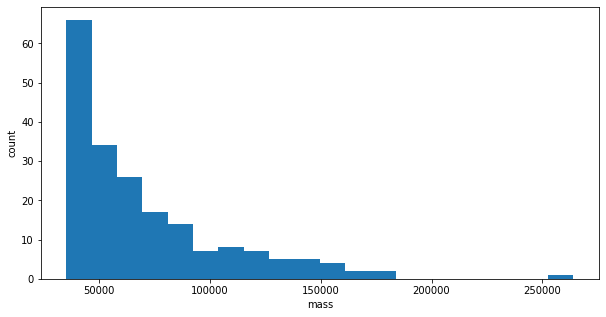

In [8]:
fig, ax = plt.subplots()
ax.hist(f_0['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

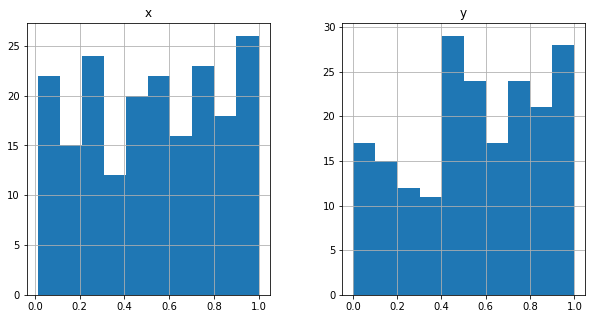

In [9]:
tp.subpx_bias(f_0)

In [10]:
if not(is_variable_loaded("f")):
    f = tp.batch(frames[::], 11, invert=True, minmass=20000);
    save_table_backup(f,'f.pkl')
    display(f.head())

In [11]:
if not(is_variable_loaded("t")):
    t = tp.link(f, 5, memory=3)
    save_table_backup(t,"t.pkl")
    display(t.head())

In [12]:
if not(is_variable_loaded("t1")):
    t1 = tp.filter_stubs(t, 2)
    # Compare the number of particles in the unfiltered and filtered data.
    print('Before:', t['particle'].nunique())
    print('After:', t1['particle'].nunique())
    save_table_backup(t1, 't1.pkl')
    display(t1.head())

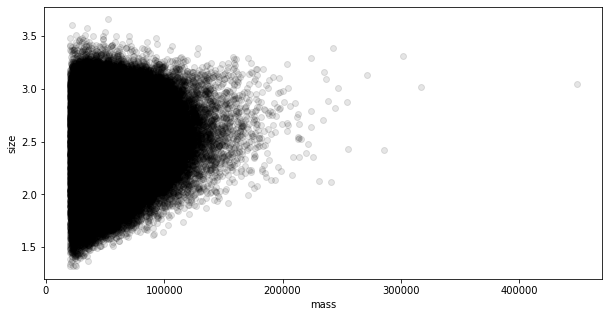

In [13]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [14]:
if not(is_variable_loaded("t2")):
    t2 = t1[((t1['mass'] < 80000) & (t1['size'] < 3.00))]
    save_table_backup(t2, "t2.pkl")
    display(t2.head())

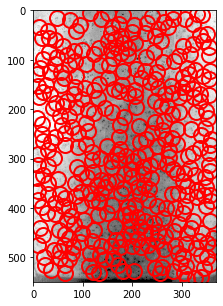

In [15]:
plt.figure()
frame_no=4000
tp.annotate(t2[t2['frame'] == frame_no], frames[frame_no]);

In [16]:
# col_names = ['dx', 'dy', 'x', 'y', 'frame', 'particle']
# # Creating an empty dataframe to store results
# data = pd.DataFrame(np.zeros(shape=(1, 6), dtype=np.int64), columns=col_names)
# display(data)
    
# for item in set(t2.particle):      
#         sub = t2[t2.particle==item]
        
#         if sub.shape[0]<=2:
#             # Cases in which particle only has 1 or 2 rows of data
#             pass
#         else:    
#             ddx = pd.DataFrame(np.gradient(sub.x), columns=['dx',])
#             ddy = pd.DataFrame(np.gradient(sub.y), columns=['dy',])
        
#             new_df = pd.concat((dvx,dvy, sub.x.reset_index(drop=True), sub.y.reset_index(drop=True),
#                                 sub.frame.reset_index(drop=True), sub.particle.reset_index(drop=True)),
#                                 axis=1, names=col_names, sort=False)
#             data = pd.concat((data, new_df), axis=0)

# for item in set(data.particle):      
#         sub = data[data.particle==item]
            
            
            
# # dvx = pd.DataFrame(np.gradient(dx)/FRAME_TIME, columns=['vx',])
# # dvy = pd.DataFrame(np.gradient(dy)/FRAME_TIME, columns=['vy',])
    
# # This is to get rid of the first 'np.zeros' row and to reset indexes
# data = data.reset_index(drop=True)
# data = data.drop(0)
# data = data.reset_index(drop=True)


In [17]:
if not(is_variable_loaded("v_data")):
    
    v_data = pd.DataFrame()
    for p in set(t2.particle):
        p_data = t2[t2.particle==p]
        dx = np.diff(p_data.x)
        dy = np.diff(p_data.y)
        dt = np.diff(p_data.frame)/FRAMES_PER_SECOND
        v = np.sqrt(dx**2+dy**2)/dt
        vx = dx/dt
        vy = dy/dt

        new_df = pd.concat((p_data.x.reset_index(drop=True), p_data.y.reset_index(drop=True), pd.Series(abs(dx)).rename("dx"), 
                            pd.Series(abs(dy)).rename("dy"), pd.Series(v).rename("v"), pd.Series(vx).rename("vx"),pd.Series(vy).rename("vy"),pd.Series(dt).rename("dt"), p_data.frame.reset_index(drop=True), 
                            p_data.particle.reset_index(drop=True)), axis=1, sort=False)
        v_data = pd.concat((v_data, new_df), axis=0)
    
    save_table_backup(v_data,'v_data.pkl')
    print(v_data['vx'].min(), v_data['vx'].max())
    print(v_data['vy'].min(),v_data['vy'].max())
    display(v_data.head(20))

In [18]:
if not(is_variable_loaded("v_data_filtered")):
    v_data_filtered = v_data[(v_data['y'] > (0)) & ((np.absolute(v_data['v'])) > 400)]
    print(v_data_filtered['vx'].min(), v_data_filtered['vx'].max())
    print(v_data_filtered['vy'].min(),v_data_filtered['vy'].max(), v_data_filtered.shape)
    save_table_backup(v_data_filtered, 'v_data_filtered.pkl')
    display(v_data_filtered.head(20))

-2416.5200950321746 2413.8598987102814
-2416.217986768862 2416.5529257124235 (727356, 10)


x           y        dx        dy            v           vx  \
4    263.225254    4.654430  0.964970  0.201928   476.501232  -466.399081   
68   261.140242    4.302150  0.873344  0.070924   423.503209   422.113582   
360  262.207836    4.641802  0.928963  0.064787   450.086479   448.995895   
0     89.804310  410.431634  4.980748  0.372807   603.519771   601.836244   
1     94.785059  410.804441  3.858786  1.307842   492.319141   466.266783   
0    266.366433  412.728715  3.657369  1.163254  1854.974043  1767.716013   
0    338.950772  417.701643  0.184029  4.167719  2016.346425   -88.946925   
1    338.766743  413.533924  0.276409  4.147317  2008.969668   133.596876   
2    339.043152  409.386607  0.228519  4.038344  1954.975372  -110.450143   
3    338.814633  405.348263  0.776460  4.369080  2144.795713  -375.286223   
4    338.038173  400.979183  0.978371  3.804052  1898.448815  -472.876069   
5    337.059802  397.175131  0.074816  4.099819  1981.895269   -36.160847   
6    336.984986  393.075312  1.115301  3.770882  1900.626798  -539.058204   
0    289.157298  419.905947  0.105571  3.924049  1897.296769    51.025620   
1    289.262869  415.981899  0.850683  4.577912  2250.519747  -411.160848   
2    288.412186  411.403986  0.149699  4.581425  2215.521871   -72.354238   
3    288.262486  406.822562  0.084669  4.278165  2068.170579    40.923221   
4    288.347156  402.544396  0.098857  3.977026  1922.809790    47.780784   
5    288.446013  398.567370  1.157622  8.397674   409.723101    55.951322   
8    288.501267  389.058363  0.421113  1.067475   554.638626  -203.536308   

              vy        dt  frame  particle  
4     -97.597752  0.002069      4         0  
68     34.279605  0.002069     75         0  
360   -31.313334  0.002069    368         0  
0      45.047197  0.008276      4         3  
1    -158.029819  0.008276      8         3  
0     562.235536  0.002069      0         5  
0   -2014.383616  0.002069      0         6  
1   -2004.522636  0.002069      1         6  
2   -1951.852830  0.002069      2         6  
3   -2111.707580  0.002069      3         6  
4   -1838.612555  0.002069      4         6  
5   -1981.565354  0.002069      5         6  
6   -1822.580171  0.002069      6         6  
0   -1896.610507  0.002069      0        10  
1   -2212.642287  0.002069      1        10  
2   -2214.340088  0.002069      2        10  
3   -2067.765662  0.002069      3        10  
4   -1922.216035  0.002069      4        10  
5    -405.884797  0.020690      5        10  
8    -515.942804  0.002069     19        10

In [19]:
len(set(v_data['particle']))

220266

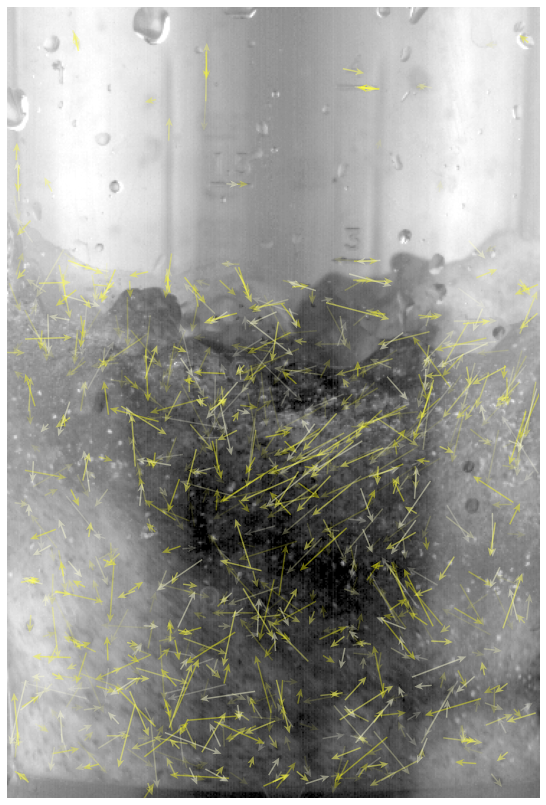

In [20]:
def random_hex(length):
    return ''.join([random.choice('ABCDEF0123456789') for i in range(length)])

scale=2
start_frame = 100
num_frames = 10
start_opacity = 0.1*255
end_opacity = int(255*0.5)
current_opacity = start_opacity
opacity_step = (end_opacity - start_opacity) / (num_frames-1)

# plt.figure()
px = 1 / plt.rcParams['figure.dpi']
linewidth = 0.4* px / scale

for i in range(start_frame, start_frame + num_frames):
    
    opacity_hex = str(hex(int(current_opacity)))[2:]
    
    random_colour = "#"+"FFFF"+random_hex(2)+opacity_hex
    colour = "#FF0000"+opacity_hex
    
    current_opacity += opacity_step
    d = v_data_filtered[v_data_filtered.frame==i]
    
    plt.imshow(frames[i])
    plt.quiver(d.x, d.y, d.vx, -d.vy, pivot='middle', headwidth=5, headlength=6, color=random_colour, width=linewidth)

    plt.axis('off')
   
fig = plt.gcf()
fig.set_size_inches(350*scale*px,524*scale*px)
plt.savefig(os.path.join(OUTPUTS_PATH,generate_filename("png")),bbox_inches='tight', pad_inches=0)


In [21]:
v_data.shape

(727356, 10)

In [183]:
key = 'vy'

print(v_data_filtered.shape)

print(f"Average of column {key} is {np.average(v_data_filtered[key])}")
print(f"Median of column {key} is {np.median(v_data_filtered[key])}")

v_data_min = v_data_filtered[v_data_filtered['frame'] < 100]
print(v_data_min.shape)
print(len(set(v_data_min['particle'])))

(727356, 10)
Average of column vy is 356.75399006347226
Median of column vy is 437.1349748828437
(7637, 10)
3706


[370, 550]
0.013888888888888888


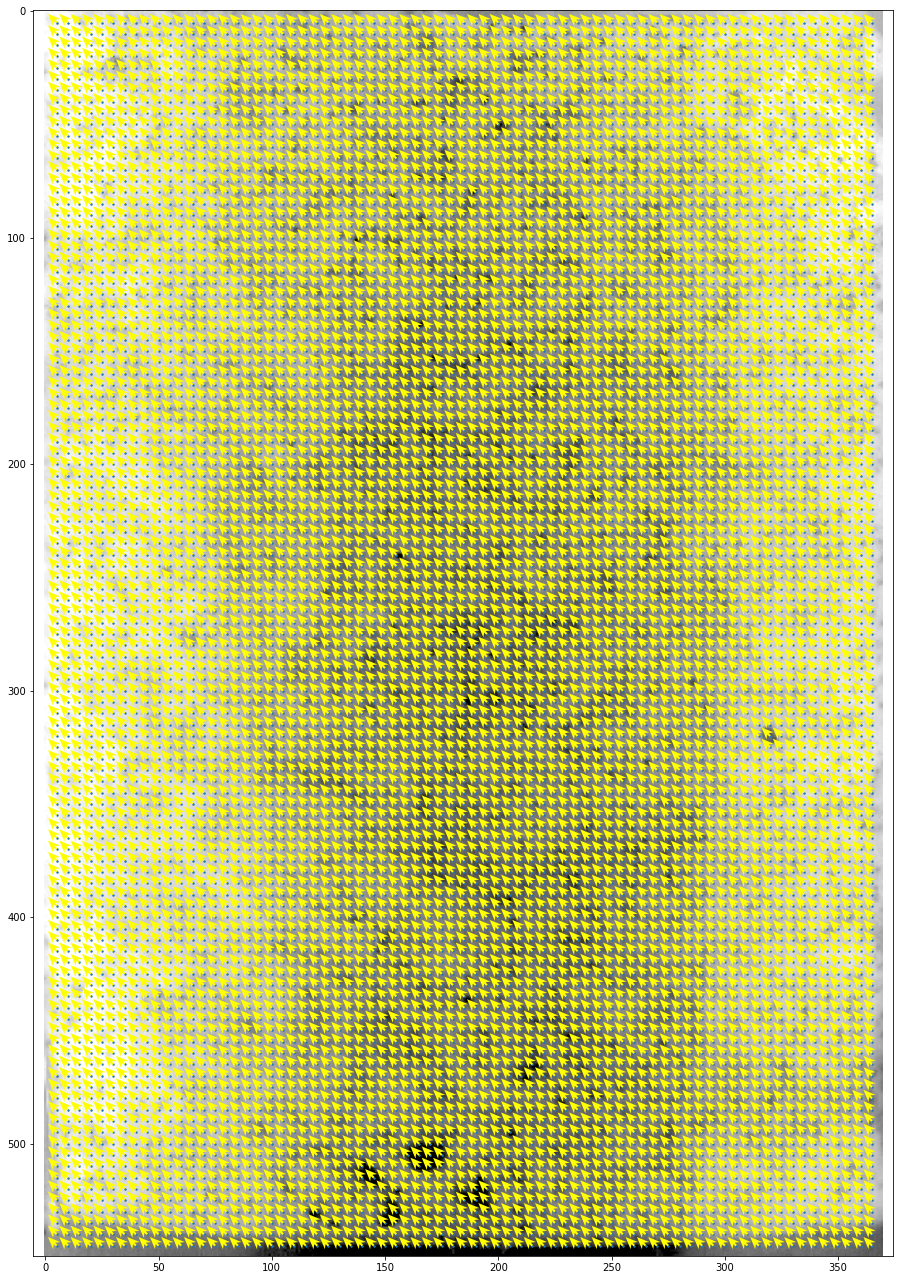

In [276]:
cols  = ['x', 'y', 'grid_point']
kek = pd.DataFrame(np.zeros(shape=(1, 3), dtype=np.int64), columns=cols)


image_size = [frames[0].shape[1], frames[0].shape[0]]
print(image_size)

point_spacing = 5
Ypts = np.arange(5, image_size[1], point_spacing)
Xpts = np.arange(5, image_size[0], point_spacing)

max_point_distance = point_spacing / 2

X2D,Y2D = np.meshgrid(Ypts,Xpts)

out = pd.DataFrame(np.column_stack((Y2D.ravel(),X2D.ravel())),columns=['x_coord','y_coord'])

# rng = np.random.default_rng(12345)

out['dx'] = -1
out['dy'] = 1


# display(out)


scale = 3

mpl.rc('figure',  figsize=(image_size[0]*scale*px,image_size[1]*scale*px))
            
plt.imshow(frames[1000])
plt.scatter(out['x_coord'],out['y_coord'],s=50*scale*px)
plt.axis('equal')
plt.quiver(out['x_coord'],out['y_coord'],out['dx'],out['dy'], headwidth=5, headlength=6,color="#ffff00", scale=100)
fig.set_size_inches(image_size[0]*scale*px,image_size[1]*scale*px)
print(px)

In [277]:
import math

dist = 0

distances = []


point = [365,525]
sub = pd.DataFrame()
display(distances)

for particle in set(v_data_min['particle']):
    sub = v_data_min[v_data_min['particle'] == particle]
    
    if (particle > 0 and particle < 0):
        
        for frame in set(sub['frame']):
            sub_frame = sub[sub['frame'] == frame]
            x_coord = sub_frame['x']
            y_coord = sub_frame['y']


            dx = (point[0] - x_coord)**2
            dy = (point[1] - y_coord)**2

            dist = math.sqrt(dx+dy)
            distances.append(dist)
#             print(sub_frame.index)

distances = pd.DataFrame(distances, columns=['kek'])        
# display(distances)
print(distances.min())

print(f"distances shape: {distances.shape}")
print(f"v_data_min shape: {v_data_min.shape}")

# v_data_min = pd.concat((v_data_min, distances))
# display(v_data_min)


[]

kek    NaN
dtype: object
distances shape: (0, 1)
v_data_min shape: (7637, 10)


In [181]:
# display(distances.head(10))
display(v_data_min.head(150))

x           y        dx        dy            v           vx  \
4   263.225254    4.654430  0.964970  0.201928   476.501232  -466.399081   
0    89.804310  410.431634  4.980748  0.372807   603.519771   601.836244   
1    94.785059  410.804441  3.858786  1.307842   492.319141   466.266783   
0   266.366433  412.728715  3.657369  1.163254  1854.974043  1767.716013   
0   338.950772  417.701643  0.184029  4.167719  2016.346425   -88.946925   
..         ...         ...       ...       ...          ...          ...   
3    29.643810  449.541989  1.438490  0.372509   718.199053   695.265304   
4    31.082300  449.914498  0.645214  1.384333   738.194958   311.851111   
5    31.727513  451.298830  0.260325  2.101890  1023.668425  -125.822930   
7    31.094921  448.686863  0.140459  3.764015   455.131849   -16.972034   
8    30.954462  452.450877  0.155076  2.422596  1173.310065   -74.953040   

             vy        dt  frame  particle  
4    -97.597752  0.002069      4         0  
0     45.047197  0.008276      4         3  
1   -158.029819  0.008276      8         3  
0    562.235536  0.002069      0         5  
0  -2014.383616  0.002069      0         6  
..          ...       ...    ...       ...  
3    180.044541  0.002069      8       103  
4    669.089441  0.002069      9       103  
5  -1015.906312  0.002069     10       103  
7    454.815292  0.008276     12       103  
8  -1170.913554  0.002069     16       103  

[150 rows x 10 columns]

In [ ]:
col_names = ['dx', 'dy', 'x', 'y', 'frame', 'particle']
# Creating an empty dataframe to store results
data = pd.DataFrame(np.zeros(shape=(1, 6), dtype=np.int64), columns=col_names)
display(data)
    
for item in set(t2.particle):      
        sub = t2[t2.particle==item]
        
        if sub.shape[0]<=2:
            # Cases in which particle only has 1 or 2 rows of data
            pass
        else:    
            ddx = pd.DataFrame(np.gradient(sub.x), columns=['dx',])
            ddy = pd.DataFrame(np.gradient(sub.y), columns=['dy',])
        
            new_df = pd.concat((dvx,dvy, sub.x.reset_index(drop=True), sub.y.reset_index(drop=True),
                                sub.frame.reset_index(drop=True), sub.particle.reset_index(drop=True)),
                                axis=1, names=col_names, sort=False)
            data = pd.concat((data, new_df), axis=0)

for item in set(data.particle):      
        sub = data[data.particle==item]
            
            
            
# dvx = pd.DataFrame(np.gradient(dx)/FRAME_TIME, columns=['vx',])
# dvy = pd.DataFrame(np.gradient(dy)/FRAME_TIME, columns=['vy',])
    
# This is to get rid of the first 'np.zeros' row and to reset indexes
data = data.reset_index(drop=True)
data = data.drop(0)
data = data.reset_index(drop=True)